# Libraries

In [515]:
import sys
sys.path.append('/home/zoro/MineDeep-master/MineDeep/minedeep_crawler')

from crawler.networkCrawler import Crawler
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stt
import matplotlib.pyplot as plt

# Goals
## Main goal:
Create a high accuracy user classifier
## Secondary goal:
Use our tweets classifier to find tweets connected to pro-BDS sentiment and overcome the neurtral sentiment

# Preperation 

## Initialize crawler

In [105]:
my_crawler = Crawler(100, datetime.datetime(2018, 2, 1), datetime.datetime(2018, 2, 31))
my_crawler.workers_manager.generate_workers()
worker1 = my_crawler.workers_manager.user_workers[0]
my_crawler.already_processed = []
my_crawler.supporters = []

## Construct user's lists

In [276]:
advanced_level_2 = [15721256,248670810,24924400,226350647, 207901468,46678624, 17740486, 16799023, 33960482,33519870,
					296005306,81136269,78706973,23947806,34002725,15822295,46339623,3006185079,263475932,
                    19912781,62594204, 47646735,17654763, 20796969,414962189,253035662,7125512,18874964,
					87401080,16753540, 271787365, 2704577472,325480259,890656879,32485683,
                    245480847,160044700,2421047521,725409470,14890970,569544773,
                    102918877,104815494,110793156,111186363,127520844,130586799,151825970,18693861,188737021]
active_level_2 = [15916118, 611532667, 212973087, 23187207, 31135856,18320938,13870942,33025341,1387828454,
				 3254830066,14981648,279360261,15634728,1272809024,357325029,1046114347,26471066,88868969,21501875,
                 15776713,50979116,46359078, 98519038, 4685083651,6392972, 23053980,289887039,125671954,
                 1633259659,257593,147896957,39246283,74323323,372050829,868621405,27187343,19543062,3385068466,
                 254873869,48956231,340418291,24537270,37501003,25298569,61375366,23109598,312696314,6392972,
                 1591861232,17606709]
other_level_2 = [100001518,1005017054,1047048570,108554712,114003485, 116234223, 1164783247, 245725998, 22504089,
                 19489239,4695617526,24713327,18085903,2714031800,19792064,223476311,312235940,21227248,2307125475,
                 245741457,867351204917071872,884053319924277248,737387991820296192,714395530558894081,3239855940,
                 2811362719,349047223,16314859,205757141,524351758,35825392,14230524,14426771,262794965,234614864,
                 234720983,23473550,23487237,2348928990,2349040202,234966107,23503830,828255014925824001,521119124,
                 4927593075,15987296,1950513457,16330790,752106977220763648,431969214]


## DF for data collection

In [280]:
users_classification = pd.DataFrame(columns=['user_id', 'tweets_count', 'type', 'filtered_count', 
                                             'filtered_prcnt', 'score_+0', 'score_0.25', 'score_0.5',
                                             'score_0.65', 'score_0.75', 'score_0.8', 'score_0.9', 
                                             'score_1', 'score_1.25', 'score_1.5', 'score_2',
                                             'score_-0', 'score_-0.25', 'score_-0.5', 'score_-0.65',
                                             'score_-0.75', 'score_-0.8', 'score_-0.9', 'score_-1',
                                             'score_-1.25', 'score_-1.5', 'score_-2',
                                             'quant25_dis_ok', 'mean_dis_ok', 'median_dis_ok',
                                             'quant25_dis', 'mean_dis', 'median_dis',
                                             'bfs_level'])


## Collect data

In [281]:
words = ['isra', 'pales', 'zion', 'bds', 'jew', 'gaza', 'netanyahu', 'jerusalem', 'idf',
         'tamimi', 'ahed','apartheid']

missing_advanced = []
missing_active = []
missing_other = []
groups = {'pro - advanced active': advanced_level_2, 'pro - active': active_level_2, 'other': other_level_2}
for user_type, array in groups.items():
    for user_id in array:
        tweets = worker1.collector.collect_tweets(user_id, worker1)
        texts = [tweet.full_text for tweet in tweets]
        if len(texts)==0:
            if user_type == 'pro - advanced active':
                missing_advanced.append(user_id)
            if user_type == 'pro - active':
                missing_active.append(user_id)
            if user_type == 'other':
                missing_other.append(user_id)
            continue
        results = worker1.classifier.ml_classifier.predict(texts)
        total = len(results)
        cnt = 0
        indexes_ok = []
        indexes_not_ok = []
        index = 0
        for text in texts:
            not_ok = True
            processed_text = worker1.classifier.ml_classifier.proccessor.proccess_tweet(text)
            for word in words:
                if word in processed_text:
                    cnt = cnt + 1
                    indexes_ok.append(index)
                    not_ok = False
                    break
            if not_ok:
                indexes_not_ok.append(index)        
            index = index + 1
        temp_df = pd.DataFrame(list(zip(texts, results)), columns=['text', 'decision_boundary'])
        users_classification = users_classification.append({'user_id': str(user_id),
                                                'tweets_count': len(results),
                                                'type': user_type,
                                                'filtered_count': cnt,
                                                'filtered_prcnt': cnt/len(results),
                                                'score_+0': sum(results>0)/total,
                                                'score_0.25': sum(results>0.25)/total,
                                                'score_0.5': sum(results>0.5)/total,
                                                'score_0.65': sum(results>0.65)/total,
                                                'score_0.75': sum(results>0.75)/total,
                                                'score_0.8': sum(results>0.8)/total,
                                                'score_0.9': sum(results>0.9)/total,
                                                'score_1': sum(results>1)/total,
                                                'score_1.25': sum(results>1.25)/total,
                                                'score_2': sum(results>2)/total,
                                                'score_-0': sum(results<0)/total,
                                                'score_-0.25': sum(results<-0.25)/total,
                                                'score_-0.5': sum(results<-0.5)/total,
                                                'score_-0.65': sum(results<-0.65)/total,
                                                'score_-0.75': sum(results<-0.75)/total,
                                                'score_-0.8': sum(results<-0.8)/total,
                                                'score_-0.9': sum(results<-0.9)/total,
                                                'score_-1': sum(results<-1)/total,
                                                'score_-1.25': sum(results<-1.25)/total,
                                                'score_-1.5': sum(results<-1.5)/total,
                                                'score_-2': sum(results<-2)/total,
                                                'quant25_dis_ok':temp_df.decision_boundary[indexes_ok].quantile(0.25),
                                                'mean_dis_ok':temp_df.decision_boundary[indexes_ok].mean(),
                                                'median_dis_ok':temp_df.decision_boundary[indexes_ok].median(),
                                                'quant25_dis':np.percentile(results, 0.25),
                                                'mean_dis':np.mean(results),
                                                'median_dis':np.median(results)}, ignore_index=True)

In [296]:
# store data in a pickle file
df = pd.DataFrame(users_classification)
df.to_pickle('/home/zoro/MineDeep-master/users-classification-analysis/data/boundaries_analysis.pickle')
pd.set_option('display.max_rows', 500)
df

,user_id,tweets_count,type,filtered_count,filtered_prcnt,score_+0,score_0.25,score_0.5,score_0.65,score_0.75,...,score_-1.25,score_-1.5,score_-2,quant25_dis_ok,mean_dis_ok,median_dis_ok,quant25_dis,mean_dis,median_dis,bfs_level
0,100001518,3,other,0,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,-1.193653,-0.337529,-0.196306,NaN
1,1005017054,1473,other,126,0.085540,0.250509,0.139172,0.076035,0.048880,0.042091,...,0.093007,0.055669,0.021724,-1.496918,-0.922104,-0.990683,-3.131013,-0.372906,-0.274300,NaN
2,1047048570,4,other,1,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.073057,-0.073057,-0.073057,-0.584121,-0.251190,-0.186196,NaN
3,108554712,28,other,5,0.178571,0.071429,0.035714,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.816402,-0.361151,-0.523686,-0.873866,-0.418629,-0.489022,NaN
4,114003485,8,other,2,0.250000,0.125000,0.125000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.434619,-0.196306,-0.196306,-0.670860,-0.361561,-0.432693,NaN
5,116234223,215,other,160,0.744186,0.144186,0.097674,0.060465,0.046512,0.041860,...,0.320930,0.218605,0.125581,-1.527248,-0.931201,-0.862620,-3.828933,-0.897360,-0.755740,NaN
6,1164783247,83,other,1,0.012048,0.072289,0.036145,0.000000,0.000000,0.000000,...,0.168675,0.024096,0.000000,0.280320,0.280320,0.280320,-1.914192,-0.637863,-0.543906,NaN
7,245725998,796,other,3,0.003769,0.187186,0.079146,0.037688,0.025126,0.022613,...,0.011307,0.000000,0.000000,-0.372032,-0.296125,-0.254079,-1.350981,-0.228376,-0.254079,NaN
8,22504089,80,other,1,0.012500,0.175000,0.087500,0.050000,0.037500,0.025000,...,0.000000,0.000000,0.000000,0.764649,0.764649,0.764649,-1.063166,-0.219114,-0.254079,NaN
9,19489239,2360,other,748,0.316949,0.128814,0.065678,0.037712,0.023729,0.018220,...,0.076271,0.043220,0.011017,-0.826993,-0.409752,-0.371551,-2.352936,-0.448362,-0.254079,NaN


## Data distribution
We need to check if the data represent a wide a range of tweets_count as to get a better general picture.

In [387]:
# make sure we got the right samaples size
df.type.value_counts()

pro - active             50
pro - advanced active    50
other                    50
Name: type, dtype: int64

Text(0.5,1,'"pro - advanced active" histogram')

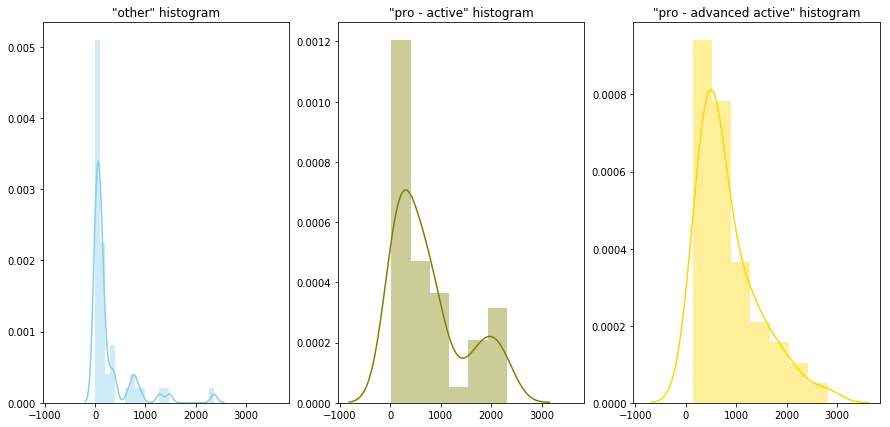

In [511]:
f, axes = plt.subplots(1, 3, figsize=(15, 7), sharex=True)
a = sns.distplot( df.tweets_count[df.type=='other'].tolist() , color="skyblue", ax=axes[0])
a.set_title('"other" histogram')
b = sns.distplot( df.tweets_count[df.type=='pro - active'].tolist() , color="olive", ax=axes[1])
b.set_title('"pro - active" histogram')
c = sns.distplot( df.tweets_count[df.type=='pro - advanced active'].tolist() , color="gold", ax=axes[2])
c.set_title('"pro - advanced active" histogram')


Text(0.5,1,'Users type total tweets count')

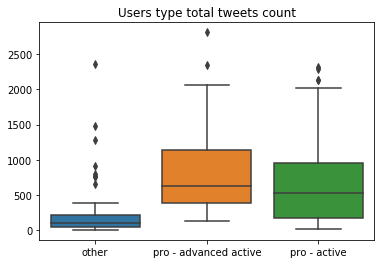

In [477]:
sns.boxplot(x=df.type.tolist(), y=df.tweets_count.tolist())
plt.title('Users type total tweets count')

Text(0.5,1,'Users type bds connected tweets count')

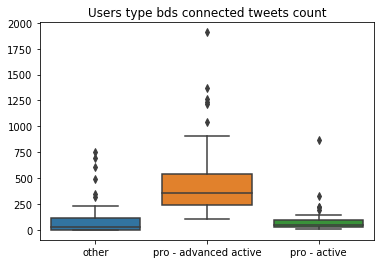

In [478]:
sns.boxplot(x=df.type.tolist(), y=df.filtered_count.tolist())
plt.title('Users type bds connected tweets count')

### Summary
Although, we can't see a perfect match  between each user type range of tweets count, the tweets range fit the user_type tweets count population range. "pro - advanced active" group has more tweets than the other as aspected, "pro - active" has a wide range with most tweets count under 1000 tweets and "other" group has a smaller range with smaller values as half of the users are against bds users that not tweeting too much. 

# Data results visualization

(0, 1.1)

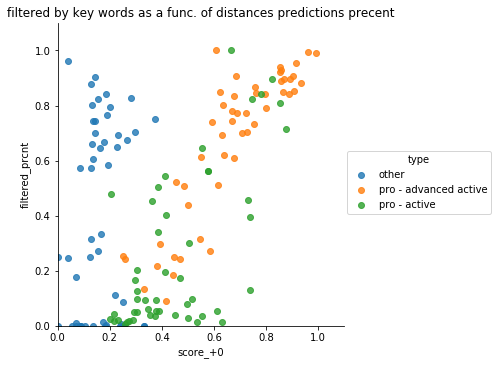

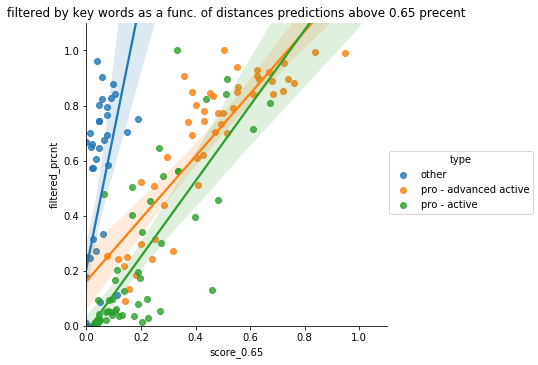

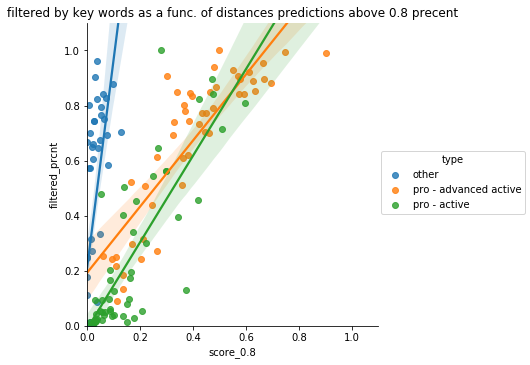

In [459]:

sns.lmplot(x='score_+0', y='filtered_prcnt', data=df, hue='type', size=5, fit_reg=False)
plt.title('filtered by key words as a func. of distances predictions precent')
plt.ylim(0, 1.1)
plt.xlim(0, 1.1)
sns.lmplot(x='score_0.65', y='filtered_prcnt', data=df, hue='type',  size=5, fit_reg=True)
plt.title('filtered by key words as a func. of distances predictions above 0.65 precent')
plt.ylim(0, 1.1)
plt.xlim(0, 1.1)
sns.lmplot(x='score_0.8', y='filtered_prcnt', data=df, hue='type',  size=5, fit_reg=True)
plt.title('filtered by key words as a func. of distances predictions above 0.8 precent')
plt.ylim(0, 1.1)
plt.xlim(0, 1.1)

In [396]:
stt.pearsonr(df.loc[df.type=='pro - active','score_0.65'], df.filtered_prcnt[df.type=='pro - active'])

(0.7765973712268629, 3.4007148759341995e-11)

In [397]:
stt.pearsonr(df.loc[df.type=='pro - active','score_0.8'], df.filtered_prcnt[df.type=='pro - active'])

(0.80700784300867656, 1.4710752658566906e-12)

### Summary
We can see that for "other" group the threshold should be 0.3 score_+0. For the "pro - advanced group we have a good 45 degree linear line relation above the 0.6 score_+0. For the "pro - active" froup we don't have any cerntainty with the score_+0. When we user a greater confidence with using  the score_0.65 (95% confidence calculated in the tweets classifier analysis) we get a better linear connection for both the "pro - active" and the domain of "other" lower than 0.6. Using 0.8 as a distance threshold will give us even better confidence, combining the fact that is a small sample size we should use it as our threshold.

__Decision:__

1. Under 0.3 precent of the tweets prediction distance whon are geater than zero will be classified as "other". 

2. Above 0.6 we take all the tweets having a prediction distance score above 0. The classification depends on the day average on how we decide if it will be classified as "pro - active" or "pro - advanced active. 

3. Between 0.3-0.6 we will use extra confidence with taking the tweets having prediction distance higher than 0.8. The classification depends on the day average on how we decide if it will be classified as "pro - active" or "pro - advanced active.

__Note:__

The "other" group has a high use of the filtering words. The classifier can detect what is the sentiment with the use of those words although we defined them as pro - BDS words. We can the aexample below with the tweets content. 

In [139]:
tweets = worker1.collector.collect_tweets(867351204917071872, worker1)
texts = [tweet.full_text for tweet in tweets]
results = worker1.classifier.ml_classifier.predict(texts)
processed_text = [worker1.classifier.ml_classifier.proccessor.proccess_tweet(text) for text in texts]
df_tweets = pd.DataFrame({'Prediction': results, 'Text': processed_text})
pd.set_option('display.max_colwidth', -1)
df_tweets

,Prediction,Text
0,-2.394563,create generation terrorists young children trained hamas terrorists carry terror operations kindergarten graduation ceremony gaza strip teaching terror child abuse
1,-1.078305,yet another hamas attack tunnel neutralized today israel one near kerem shalom humanitarian crossing #hamas #terror tunnel destroyed #gaza since
2,-0.716262,multiple barrages rockets fired palestinian terrorists #gaza southern israel making largest attack israeli communities since continue build future palestinians continue build chaos despair
3,0.078115,ask read post would happy retweet
4,0.098335,today revealed #eu continues give millions taxpayer money ngos promoting anti-israel boycotts tied eu-designated terror orgs call hr vp @federicamog uphold eu declared policy opposing #bds immediately end funding
5,-0.144311,awkward since israel withdrew @governmentza
6,-0.797144,reuters israel calls eu stop funding groups promoting anti-israel boycotts
7,0.312095,israel calls #eu end funding pro-boycott groups
8,-1.045567,#breaking israel calls #eu stop funding groups promoting anti-israel boycotts
9,-1.614630,hamas chief marches decided turn dear us bodies women children dam prevent racing many arabs towards normalization ties plundering entity occupies jerusalem defiles holy places


# Testing our classifier

In [463]:
# Define thresholds
other_threshold = 0.3
pro_low_confidence_threshold = 0.6

Differenct precnet mean: 0.001


Text(0.5,1,'"other" error histogram')

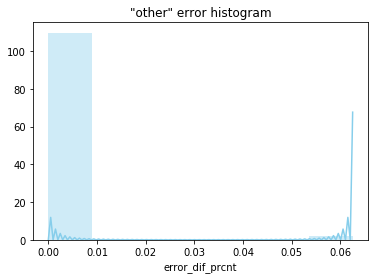

In [512]:
# "other" df init
other_analysis_df = df.loc[df.type=='other', ['user_id', 'tweets_count','filtered_prcnt',
                                              'filtered_count', 'score_+0', 'score_0.8']]

# count tweets above pro_low_confidence_threshold
other_analysis_df['pred_count'] = other_analysis_df.tweets_count[other_analysis_df['score_+0']>=pro_low_confidence_threshold]*\
                                  other_analysis_df.loc[other_analysis_df['score_+0']>=pro_low_confidence_threshold ,'score_+0']
# count tweets betweetn pro_low_confidence_threshold and other_threshold with 0.8 distance confidence
other_analysis_df.loc[np.isnan(other_analysis_df['pred_count'].tolist()) ,'pred_count'] = other_analysis_df.tweets_count[(other_analysis_df['score_+0']>=other_threshold)&\
                                                                                         (other_analysis_df['score_+0']<pro_low_confidence_threshold)]*\
                                                                                          other_analysis_df.loc[(other_analysis_df['score_+0']>=other_threshold)&\
                                                                                                                (other_analysis_df['score_+0']<pro_low_confidence_threshold), 'score_0.8']
# count tweets below other_threshold
other_analysis_df.loc[np.isnan(other_analysis_df['pred_count'].tolist()) ,'pred_count'] = other_analysis_df.tweets_count[other_analysis_df['score_+0']<other_threshold]*0


# tweets precent above pro_low_confidence_threshold
other_analysis_df['pred_final_prcnt'] = other_analysis_df.loc[other_analysis_df['score_+0']>=pro_low_confidence_threshold ,'score_+0']
# tweets precent betweetn pro_low_confidence_threshold and other_threshold with 0.8 distance confidence
other_analysis_df.loc[np.isnan(other_analysis_df['pred_final_prcnt'].tolist()) ,'pred_final_prcnt'] = other_analysis_df.loc[(other_analysis_df['score_+0']>=other_threshold)&\
                                                                            (other_analysis_df['score_+0']<pro_low_confidence_threshold), 'score_0.8']
# tweets precent below other_threshold
other_analysis_df.loc[np.isnan(other_analysis_df['pred_final_prcnt'].tolist()) ,'pred_final_prcnt'] = other_analysis_df.loc[other_analysis_df['score_+0']<other_threshold ,'score_+0']*0

# tweets filtered precent and tweets classifier precent difrence error
other_analysis_df['error_dif_prcnt'] = np.abs(np.zeros(50) - other_analysis_df.pred_final_prcnt)
# mean error
mean_error_dif = np.mean(other_analysis_df.error_dif_prcnt)
print('Differenct precnet mean: {0:.3f}'.format(mean_error_dif))
# histogram error
sns.distplot(other_analysis_df.error_dif_prcnt , color="skyblue", label="precent difference error")
plt.title('"other" error histogram')

In [488]:
other_analysis_df

,user_id,tweets_count,filtered_prcnt,filtered_count,score_+0,score_0.8,pred_count,pred_final_prcnt,error_dif_prcnt
0,100001518,3,0.000000,0,0.333333,0.000000,0,0.0000,0.0000
1,1005017054,1473,0.085540,126,0.250509,0.038697,0,0.0000,0.0000
2,1047048570,4,0.250000,1,0.000000,0.000000,0,0.0000,0.0000
3,108554712,28,0.178571,5,0.071429,0.000000,0,0.0000,0.0000
4,114003485,8,0.250000,2,0.125000,0.000000,0,0.0000,0.0000
5,116234223,215,0.744186,160,0.144186,0.027907,0,0.0000,0.0000
6,1164783247,83,0.012048,1,0.072289,0.000000,0,0.0000,0.0000
7,245725998,796,0.003769,3,0.187186,0.021357,0,0.0000,0.0000
8,22504089,80,0.012500,1,0.175000,0.012500,0,0.0000,0.0000
9,19489239,2360,0.316949,748,0.128814,0.016525,0,0.0000,0.0000


Differenct precnet mean: 0.15


Text(0.5,1,'"pro - active" error histogram')

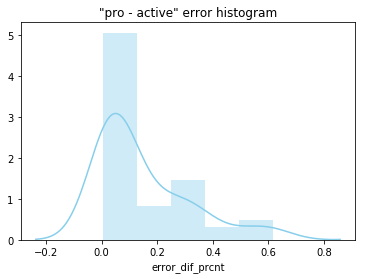

In [513]:
# "pro - active" df init
active_analysis_df = df.loc[df.type=='pro - active', ['user_id', 'tweets_count','filtered_prcnt',
                                                      'filtered_count', 'score_+0', 'score_0.8']]

# count tweets above pro_low_confidence_threshold
active_analysis_df['pred_count'] = active_analysis_df.tweets_count[active_analysis_df['score_+0']>=pro_low_confidence_threshold]*\
                                  active_analysis_df.loc[active_analysis_df['score_+0']>=pro_low_confidence_threshold ,'score_+0']
# count tweets betweetn pro_low_confidence_threshold and other_threshold with 0.8 distance confidence
active_analysis_df.loc[np.isnan(active_analysis_df['pred_count'].tolist()) ,'pred_count'] = active_analysis_df.tweets_count[(active_analysis_df['score_+0']>=other_threshold)&\
                                                                                         (active_analysis_df['score_+0']<pro_low_confidence_threshold)]*\
                                                                                          active_analysis_df.loc[(active_analysis_df['score_+0']>=other_threshold)&\
                                                                                                                (active_analysis_df['score_+0']<pro_low_confidence_threshold), 'score_0.8']
# count tweets below other_threshold
active_analysis_df.loc[np.isnan(active_analysis_df['pred_count'].tolist()) ,'pred_count'] = active_analysis_df.tweets_count[active_analysis_df['score_+0']<other_threshold]*0


# tweets precent above pro_low_confidence_threshold
active_analysis_df['pred_final_prcnt'] = active_analysis_df.loc[active_analysis_df['score_+0']>=pro_low_confidence_threshold ,'score_+0']
# tweets precent betweetn pro_low_confidence_threshold and other_threshold with 0.8 distance confidence
active_analysis_df.loc[np.isnan(active_analysis_df['pred_final_prcnt'].tolist()) ,'pred_final_prcnt'] = active_analysis_df.loc[(active_analysis_df['score_+0']>=other_threshold)&\
                                                                            (active_analysis_df['score_+0']<pro_low_confidence_threshold), 'score_0.8']
# tweets precent below other_threshold
active_analysis_df.loc[np.isnan(active_analysis_df['pred_final_prcnt'].tolist()) ,'pred_final_prcnt'] = active_analysis_df.loc[active_analysis_df['score_+0']<other_threshold ,'score_+0']*0
# tweets filtered precent and tweets classifier precent difrence error
active_analysis_df['error_dif_prcnt'] = np.abs(active_analysis_df.filtered_prcnt - active_analysis_df.pred_final_prcnt)
# mean error
mean_error_dif = np.mean(active_analysis_df.error_dif_prcnt)
print('Differenct precnet mean: {0:.2f}'.format(mean_error_dif))
# histogram error
sns.distplot(active_analysis_df.error_dif_prcnt , color="skyblue", label="precent difference error")
plt.title('"pro - active" error histogram')

In [384]:
active_analysis_df

,user_id,tweets_count,filtered_prcnt,filtered_count,score_+0,score_0.8,pred_count,pred_final_prcnt,error_dif_prcnt
100,15916118,2296,0.017422,40,0.275261,0.031359,0,0.000000,0.017422
101,611532667,1786,0.034714,62,0.554311,0.134378,240,0.134378,0.099664
102,212973087,2136,0.023876,51,0.202715,0.037921,0,0.000000,0.023876
103,23187207,865,0.038150,33,0.449711,0.100578,87,0.100578,0.062428
104,31135856,690,0.027536,19,0.500000,0.178261,123,0.178261,0.150725
105,18320938,1427,0.080589,115,0.496847,0.149264,213,0.149264,0.068676
106,13870942,932,0.054721,51,0.378755,0.085837,80,0.085837,0.031116
107,33025341,2312,0.022924,53,0.289360,0.055796,0,0.000000,0.022924
108,1387828454,929,0.203445,189,0.303552,0.086114,80,0.086114,0.117330
109,3254830066,471,0.040340,19,0.354565,0.065817,31,0.065817,0.025478


In [501]:
miss = active_analysis_df.filtered_count>active_analysis_df.pred_count
left_over = active_analysis_df.filtered_count<active_analysis_df.pred_count
diff_count_active_miss = active_analysis_df.filtered_count[miss].sum() - active_analysis_df.pred_count[miss].sum()
diff_count_active_over = np.abs(active_analysis_df.filtered_count[left_over].sum() - \
                         active_analysis_df.pred_count[left_over].sum())
higher_pred_count_precent_active = sum(active_analysis_df.filtered_count<active_analysis_df.pred_count)/50
print("True pro-BDS sentiment tweets missed: {}".format(diff_count_active_miss))
print("True pro-BDS sentiment tweets over left: {}".format(diff_count_active_over))
print("Precent of users having a predict count "
      "pro-BDS sentiments tweets than should be: {0:.2f}".format(higher_pred_count_precent_active))

True pro-BDS sentiment tweets missed: 2223.0
True pro-BDS sentiment tweets over left: 1477.0
Precent of users having a predict count pro-BDS sentiments tweets than should be: 0.36


Differenct precnet mean: 0.11


Text(0.5,1,'"pro - advanced active" error histogram')

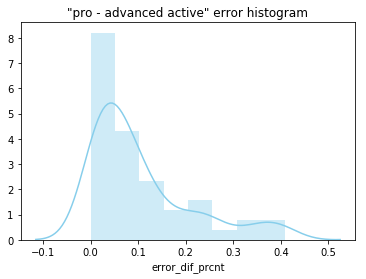

In [514]:
# "advanced active" df init
advanced_analysis_df = df.loc[df.type=='pro - advanced active', ['user_id', 'tweets_count','filtered_prcnt',
                                                                 'filtered_count', 'score_+0', 'score_0.8']]

# count tweets above pro_low_confidence_threshold
advanced_analysis_df['pred_count'] = advanced_analysis_df.tweets_count[advanced_analysis_df['score_+0']>=pro_low_confidence_threshold]*\
                                  advanced_analysis_df.loc[advanced_analysis_df['score_+0']>=pro_low_confidence_threshold ,'score_+0']
# count tweets betweetn pro_low_confidence_threshold and other_threshold with 0.8 distance confidence
advanced_analysis_df.loc[np.isnan(advanced_analysis_df['pred_count'].tolist()) ,'pred_count'] = advanced_analysis_df.tweets_count[(advanced_analysis_df['score_+0']>=other_threshold)&\
                                                                                         (advanced_analysis_df['score_+0']<pro_low_confidence_threshold)]*\
                                                                                          advanced_analysis_df.loc[(advanced_analysis_df['score_+0']>=other_threshold)&\
                                                                                                                (advanced_analysis_df['score_+0']<pro_low_confidence_threshold), 'score_0.8']
# count tweets below other_threshold
advanced_analysis_df.loc[np.isnan(advanced_analysis_df['pred_count'].tolist()) ,'pred_count'] = advanced_analysis_df.tweets_count[advanced_analysis_df['score_+0']<other_threshold]*0



# tweets precent above pro_low_confidence_threshold
advanced_analysis_df['pred_final_prcnt'] = advanced_analysis_df.loc[advanced_analysis_df['score_+0']>=pro_low_confidence_threshold ,'score_+0']
# tweets precent betweetn pro_low_confidence_threshold and other_threshold with 0.8 distance confidence
advanced_analysis_df.loc[np.isnan(advanced_analysis_df['pred_final_prcnt'].tolist()) ,'pred_final_prcnt'] = advanced_analysis_df.loc[(advanced_analysis_df['score_+0']>=other_threshold)&\
                                                                            (advanced_analysis_df['score_+0']<pro_low_confidence_threshold), 'score_0.8']
# tweets precent below other_threshold
advanced_analysis_df.loc[np.isnan(advanced_analysis_df['pred_final_prcnt'].tolist()) ,'pred_final_prcnt'] = advanced_analysis_df.loc[advanced_analysis_df['score_+0']<other_threshold ,'score_+0']*0
# tweets filtered precent and tweets classifier precent difrence error
advanced_analysis_df['error_dif_prcnt'] = np.abs(advanced_analysis_df.filtered_prcnt - advanced_analysis_df.pred_final_prcnt)
# mean error
mean_error_dif = np.mean(advanced_analysis_df.error_dif_prcnt)
print('Differenct precnet mean: {0:.2f}'.format(mean_error_dif))
# histogram error
sns.distplot(advanced_analysis_df.error_dif_prcnt , color="skyblue", label="precent difference error")
plt.title('"pro - advanced active" error histogram')

In [386]:
advanced_analysis_df

,user_id,tweets_count,filtered_prcnt,filtered_count,score_+0,score_0.8,pred_count,pred_final_prcnt,error_dif_prcnt
50,15721256,516,0.881783,455,0.934109,0.695736,482,0.934109,0.052326
51,248670810,605,0.842975,510,0.796694,0.575207,482,0.796694,0.046281
52,24924400,899,0.897664,807,0.867631,0.576196,780,0.867631,0.030033
53,226350647,622,0.692926,431,0.631833,0.324759,393,0.631833,0.061093
54,207901468,1175,0.773617,909,0.688511,0.432340,809,0.688511,0.085106
55,46678624,132,0.992424,131,0.992424,0.901515,131,0.992424,0.000000
56,17740486,686,0.739067,507,0.591837,0.329446,226,0.329446,0.409621
57,16799023,1104,0.779891,861,0.667572,0.371377,737,0.667572,0.112319
58,33960482,1409,0.215756,304,0.382541,0.107878,152,0.107878,0.107878
59,33519870,886,0.299097,265,0.393905,0.170429,151,0.170429,0.128668


In [499]:
miss = advanced_analysis_df.filtered_count>advanced_analysis_df.pred_count
left_over = advanced_analysis_df.filtered_count<advanced_analysis_df.pred_count
diff_count_advanced_miss = advanced_analysis_df.filtered_count[miss].sum() - advanced_analysis_df.pred_count[miss].sum()
diff_count_advanced_over = np.abs(advanced_analysis_df.filtered_count[left_over].sum() - \
                         advanced_analysis_df.pred_count[left_over].sum())
higher_pred_count_precent_advanced = sum(advanced_analysis_df.filtered_count<advanced_analysis_df.pred_count)/50
print("True pro-BDS sentiment tweets missed: {}".format(diff_count_advanced_miss))
print("True pro-BDS sentiment tweets over left: {}".format(diff_count_advanced_over))
print("Precent of users having a predict count "
      "pro-BDS sentiments tweets than should be: {0:.2f}".format(higher_pred_count_precent_advanced))

True pro-BDS sentiment tweets missed: 4333.0
True pro-BDS sentiment tweets over left: 236.0
Precent of users having a predict count pro-BDS sentiments tweets than should be: 0.26


## Classifier accuracy

Text(0.5,1,'User types tweets error')

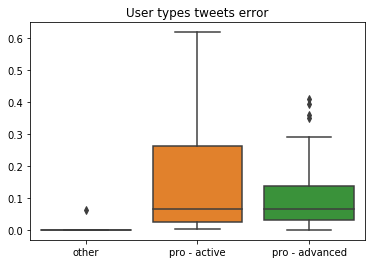

In [467]:
error_box = pd.DataFrame({'pro - advanced': advanced_analysis_df['error_dif_prcnt'],
                          'pro - active': active_analysis_df['error_dif_prcnt'],
                          'other': other_analysis_df['error_dif_prcnt']})
sns.boxplot(data=error_box) 
plt.title('User types tweets error')

In [498]:
advanced_user_accuracy = sum(advanced_analysis_df.pred_count>93)/50
active_user_accuracy = sum((active_analysis_df.pred_count>4) & (active_analysis_df['score_+0']>0.2))/50
other_user_accuracy = sum(other_analysis_df['score_+0']<0.3)/50
classifier_mean_error = (other_user_accuracy + active_user_accuracy + advanced_user_accuracy)/3
print('User type - "pro - advanced active"  classifier accuracy: {0:.2f}'.format(advanced_user_accuracy))
print('User type - "pro - active"  classifier accuracy: {0:.2f}'.format(active_user_accuracy))
print('User type - "other"  classifier accuracy: {0:.2f}'.format(other_user_accuracy))
print('User types mean classifier accuracy: {0:.2f}'.format(classifier_mean_error))

User type - "pro - advanced active"  classifier accuracy: 0.96
User type - "pro - active"  classifier accuracy: 0.76
User type - "other"  classifier accuracy: 0.94
User types mean classifier accuracy: 0.89


# Conclusion
Our classifier is not perfect, but our main goal is filled pretty good with 88% accuracy. The "pro - active" user type is our classifier main disadventage as we didn't address the neutral sentiment when building our tweets SVM classifier. However, we still have a 76% precebt accuracy which is not so bad, as "pro - active" don't tweet too much. Our secondary goal has bigger problems as we miss a 30% of tweets, but we built our classifier as stiff classifier we a higher confidence. This was done because we preffer to miss pro-BDS tweets than getting wrong sentiment pro-BDS tweets.

** __All our results must be taken cautiously due to our small sample size. The sample size size is in accordance to our time limits and our human resources__